# Crossview - Simplified

***look at pix2pix***

## Introduction

using device: cuda


/home/lrusso/miniconda3/envs/dinov2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lrusso/miniconda3/envs/dinov2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


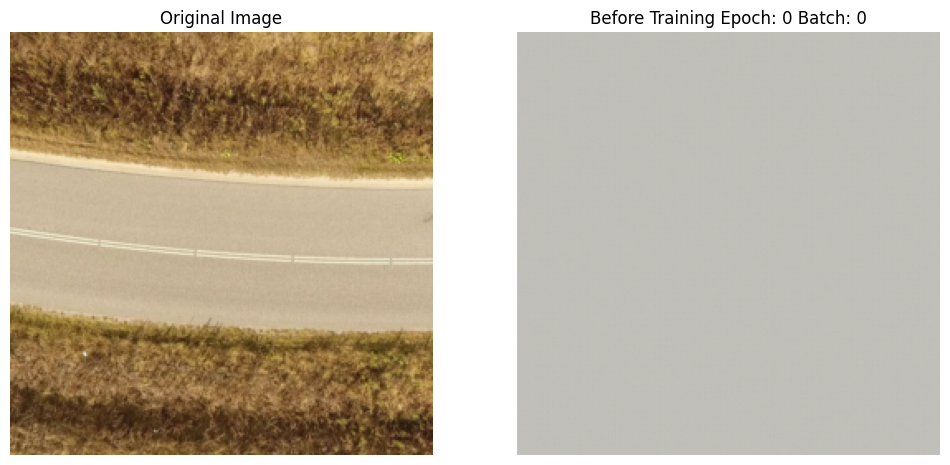

Epoch 1/3, Training:   0%|          | 0/269 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 19.71 GiB total capacity; 5.63 GiB already allocated; 169.56 MiB free; 5.93 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt
import shutil


class Encoder(nn.Module):
    def __init__(self, image_channels, hidden_dims, output_dims):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, hidden_dims, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dims, hidden_dims * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_dims * 2 * (image_size // 4) * (image_size // 4), output_dims),
            nn.ReLU()
        )
        
    def forward(self, x):
        phi = self.encoder(x)
        return phi


class Decoder(nn.Module):
    def __init__(self, input_dims, hidden_dims, image_channels, image_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims * 2 * (image_size // 4) * (image_size // 4)),
            nn.ReLU(),
            nn.Unflatten(1, (hidden_dims * 2, image_size // 4, image_size // 4)),
            nn.ConvTranspose2d(hidden_dims * 2, hidden_dims, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dims, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()    # assuming input images are normalized to [0,1]
        )
        
    def forward(self, x):
        x = self.decoder(x)
        return x
    

class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.PNG')]    # lists all PNG files in the directory

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Convert image to RGB
        
        if self.transform:
            image = self.transform(image)
        
        return image
    

def save_model(model, path):
    torch.save(model.state_dict(), path)


def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(tensor.device)
    tensor = tensor * std + mean    # denormalize
    tensor = tensor.clamp(0, 1)     # clamp to range [0, 1]
    return tensor



# ----- Setup ----- #

image_channels = 3      # for RGB images
image_size = 256        # assuming square images
hidden_dims = 256       # hidden dimensions
output_dims = 100       # size of phi
batch_size = 32
shuffle = True


encoder = Encoder(image_channels, hidden_dims, output_dims)
decoder = Decoder(output_dims, hidden_dims, image_channels, image_size)

# Loss function
criterion = nn.MSELoss()

# Optimizers
learning_rate = 1e-2
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize the shortest edge to image_size
    transforms.CenterCrop((image_size, image_size)),  # Crop the center square of the image
    transforms.ToTensor(),  # Convert images to Torch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Define the Datasets
train_dataset = CustomDataset('dataset/labelled/train/aerial', transform=transform)
val_dataset = CustomDataset('dataset/labelled/val/aerial', transform=transform)

# Define the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# ----- Training ----- #
def visualize_reconstruction(original, reconstructed, epoch, idx, title='Reconstruction'):
    # Convert tensors to PIL images
    original_img = to_pil_image(denormalize(original))
    reconstructed_img = to_pil_image(denormalize(reconstructed))
    
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(reconstructed_img)
    axs[1].set_title(f'{title} Epoch: {epoch} Batch: {idx}')
    axs[1].axis('off')
    
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")


import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features[:16]      # VGG-16
        for param in self.vgg.parameters():
            param.requires_grad = False     # freeze VGG layers

    def forward(self, reconstructed, target):
        # Normalize the images because VGG is trained on normalized images
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).to(reconstructed.device).view(-1, 1, 1)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).to(reconstructed.device).view(-1, 1, 1)
        reconstructed_norm = (reconstructed - vgg_mean) / vgg_std
        target_norm = (target - vgg_mean) / vgg_std

        # Compute features and the loss
        reconstructed_features = self.vgg(reconstructed_norm)
        target_features = self.vgg(target_norm)
        loss = nn.functional.l1_loss(reconstructed_features, target_features)
        return loss

# Set Perceptual Loss as the criterion
perceptual_loss = PerceptualLoss().to(device)
criterion = perceptual_loss


encoder.to(device)
decoder.to(device)

# Output Pre-Training
encoder.eval()
decoder.eval()

with torch.no_grad():
    for idx, images in enumerate(train_dataloader):
        images = images.to(device)
        phi = encoder(images)
        recon_images = decoder(phi)
        if idx < 1:  # show just one batch
            visualize_reconstruction(images[0], recon_images[0], 0, idx, 'Before Training')
        break


num_epochs = 3

for epoch in range(num_epochs):

    encoder.train()
    decoder.train()

    total_train_loss = 0
    
    for idx, images in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}, Training")):
        images = images.to(device)
        
        phi = encoder(images)
        recon_images = decoder(phi)
        train_loss = criterion(recon_images, images)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        train_loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        if idx % 20 == 0:  # Adjust the step for visualization frequency as needed
            visualize_reconstruction(images[0], recon_images[0], epoch+1, idx)

        total_train_loss += train_loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

    # Validation phase
    total_val_loss = 0
    
    # Switch to evaluation mode
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for images in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}, Validation"):
            images = images.to(device)
            
            # Forward pass through encoder and decoder
            phi = encoder(images)
            recon_images = decoder(phi)
            
            # Calculate loss
            val_loss = criterion(recon_images, images)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')


# Save the models
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
encoder_save_path = os.path.join(models_dir, 'encoder_model.pth')
decoder_save_path = os.path.join(models_dir, 'decoder_model.pth')
save_model(encoder, encoder_save_path)
save_model(decoder, decoder_save_path)


# ----- Inference ----- #

def inference(input_dir, output_dir):

    output_dir = os.path.join('inference', output_dir)
    
    if not os.path.exists(output_dir):      # create the output directory if it doesn't exist
        os.makedirs(output_dir)
    
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.PNG')]     # lists all PNG files in the directory
    
    for image_path in tqdm(image_paths, desc="Performing Inference"):
        
        image = Image.open(image_path).convert('RGB')       # load and transform the image
        image = transform(image).unsqueeze(0).to(device)
        
        # Perform inference
        with torch.no_grad():
            phi = encoder(image)
            recon_image = decoder(phi)
        
        # Convert tensors to PIL images for saving
        original_image = to_pil_image(denormalize(image.squeeze().cpu()))
        reconstructed_image = to_pil_image(denormalize(recon_image.squeeze().cpu()))
        
        # Extract filename and prepare output paths
        filename = os.path.basename(image_path)
        original_image_path = os.path.join(output_dir, f"original_{filename}")
        reconstructed_image_path = os.path.join(output_dir, f"reconstructed_{filename}")

        print("Original Image Stats:")
        print(f"Min: {image.min().item()}")
        print(f"Max: {image.max().item()}")
        print(f"Mean: {image.mean().item()}")

        print("Reconstructed Image Stats:")
        print(f"Min: {recon_image.min().item()}")
        print(f"Max: {recon_image.max().item()}")
        print(f"Mean: {recon_image.mean().item()}")
        
        # Save images
        original_image.save(original_image_path)
        reconstructed_image.save(reconstructed_image_path)


encoder.eval()
decoder.eval()


# Specify the input directory and the output directory
input_dir = 'test'  # Update as needed
output_dir = 'inference'  # The folder where original and result images will be saved

# Perform inference and save results
inference(input_dir, output_dir)


### Visualize Transformations

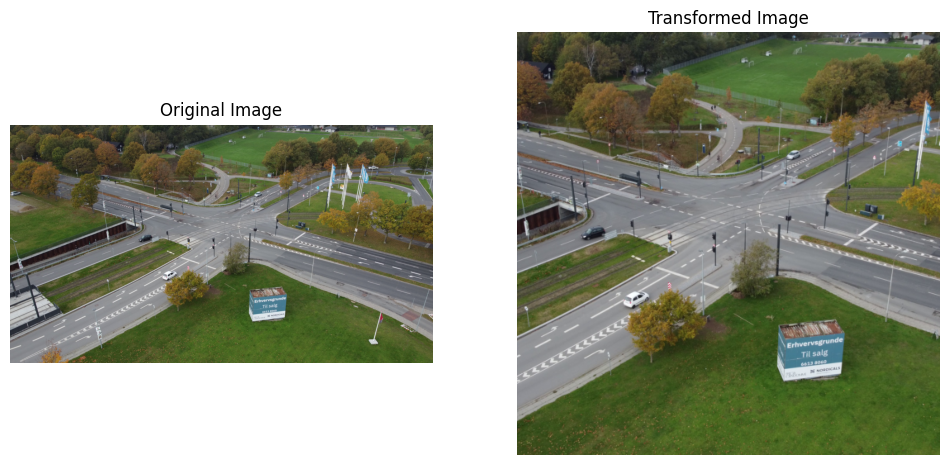

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

image_size = 512        # assuming square images

# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize the shortest edge to image_size
    transforms.CenterCrop((image_size, image_size)),  # Crop the center square of the image
    transforms.ToTensor(),  # Convert images to Torch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])


# Load Sample Image
image_path = 'dataset/labelled/train/aerial/scene_1_Cortex_Park_crossroads_drone_000000.PNG'  # Update this to the path of your image
image = Image.open(image_path).convert('RGB')

# Apply the transformation
transformed_image = transform(image)

# Denormalize the transformed image
denormalized_transformed_image = denormalize(transformed_image.squeeze())

# Convert denormalized image back to PIL for displaying
denormalized_transformed_image_pil = to_pil_image(denormalized_transformed_image)

# Display the original and denormalized transformed images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(denormalized_transformed_image_pil)
axs[1].set_title('Transformed Image')
axs[1].axis('off')

plt.show()


## Training

## Validation

## Inference

In [ ]:
# from torchvision.transforms.functional import to_tensor, to_pil_image
# import matplotlib.pyplot as plt


# # Initialize the models
# encoder = Encoder(image_channels, hidden_dims, output_dims).to(device)
# decoder = Decoder(output_dims, hidden_dims, image_channels, image_size).to(device)

# # Load the saved model weights
# encoder.load_state_dict(torch.load('encoder_model.pth', map_location=device))
# decoder.load_state_dict(torch.load('decoder_model.pth', map_location=device))

# # Set the models to evaluation mode
# encoder.eval()
# decoder.eval()


# def preprocess_image(image_path):
#     image = Image.open(image_path).convert('RGB')
#     image = transforms.Resize((64, 64))(image)  # Resize to the same size as during training
#     image = to_tensor(image)  # Convert to tensor
#     image = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image)  # Normalize
#     return image.unsqueeze(0).to(device)  # Add batch dimension and send to device


# def infer_and_plot(image_path):
#     # Preprocess the image
#     image = preprocess_image(image_path)
    
#     # Perform inference
#     with torch.no_grad():
#         phi = encoder(image)
#         recon_image = decoder(phi)
    
#     # Convert images to PIL for visualization
#     image = to_pil_image(image.squeeze().cpu())
#     recon_image = to_pil_image(recon_image.squeeze().cpu())
    
#     # Plotting
#     fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#     ax[0].imshow(image)
#     ax[0].set_title('Original Image')
#     ax[0].axis('off')
    
#     ax[1].imshow(recon_image)
#     ax[1].set_title('Reconstructed Image')
#     ax[1].axis('off')
    
#     plt.show()

# # Example usage
# image_path = 'dataset/labelled/val/aerial/scene_1_Cortex_Park_crossroads_drone_000017.PNG'
# infer_and_plot(image_path)
